## 3. Visualization

Implemented based on simulation.py given in the mini-project pdf.

I run these locally. scp several(4) data-mask pairs from ```/dtu/projects/02613_2025/data/modified_swiss_dwellings/```

```
Project folder
|    
|____data
|      |____ .npy
|      |____ .npy
|____pics
|      |____ .png
|      |____ .png
|
|____room_visualize.ipynb
```

In [ ]:
# Replace with your data directory here
LOAD_DIR = "./data/"
STORE_DIR = "./pics/"

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_rooms(building_ids:list, all_u:np.ndarray, all_mask_or_raw:np.ndarray, is_mask:bool, title="!!Title!!", save = False):
    """
    Plot room temperature - mask pairs in subplot
    Print [first 4] plots from the ./data/building_ids.txt

    Input:  building_ids: dict
            all_u: the processed ndarray
            all_mask_or_raw: mask or ndarray to be comapred
            is_mask: is the 2nd ndarray mask or some other 'colored' 
            title: suptitle, title for the whole figure
            save: save to .png or not. file name as param [title]
            [Warning] maximum 4 IDs

    Output: None
    """
    if len(building_ids) > 4:
        print("This method print first 4 plots from the ./data/building_ids.txt")
        return
    
    # Cal subplot layout
    n_rooms = len(building_ids)
    n_cols = min(4, n_rooms)  # 4 pairs maximum
    n_rows = 2                # row one: the temperature
                              # row two: the mask
    
    # Transparent figure background (2nd param)
    plt.figure(constrained_layout=True, facecolor='none')

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 6))
    
    # Make sure the axes are two-dimensional, 
    # even if there is only one pair in the dict
    if n_cols == 1:
        axes = axes.reshape(n_rows, 1)
    
    # mapping
    temp_cmap_im0 = plt.colormaps['viridis']
    (temp_cmap_im1, vmax_1) = ('binary', 1) if is_mask else (temp_cmap_im0, 25)

    # iter all pairs
    # for idx, (building_id, (domain_file, interior_file)) in enumerate(room_dict.items()):
    for idx, (bid, u, mask_or_raw) in enumerate(zip(building_ids, all_u, all_mask_or_raw)):
        
        # Row 1 --- temperature
        im0 = axes[0, idx].imshow(u, cmap=temp_cmap_im0, vmin=0, vmax=25)
        axes[0, idx].set_title(f'ID: {bid}')
        
        # Row 2 --- mask or raw
        im1 = axes[1, idx].imshow(mask_or_raw, cmap=temp_cmap_im1, vmin=0, vmax=vmax_1)
        
        # Set axis scales and labels
        for i in range(2):
            axes[i, idx].set_xticks([0, 100, 200, 300, 400, 500])
            axes[i, idx].set_yticks([0, 100, 200, 300, 400, 500])
            
    # shared color bar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im0, cax=cbar_ax)
    cbar.set_label('Temperature')
    
    fig.suptitle(title, fontweight='bold')

    # Avoid suptitle - title overlapping
    plt.subplots_adjust(top=0.88)
    # plt.savefig(title + '.svg', transparent=True)
    plt.savefig( STORE_DIR + title + '.png')

    
    return None

In [5]:
from os.path import join
import sys
import numpy as np


def load_data(load_dir, bid):
    SIZE = 512
    u = np.zeros((SIZE + 2, SIZE + 2))
    u[1:-1, 1:-1] = np.load(join(load_dir, f"{bid}_domain.npy"))
    interior_mask = np.load(join(load_dir, f"{bid}_interior.npy"))
    return u, interior_mask


def jacobi(u, interior_mask, max_iter, atol=1e-6):
    u = np.copy(u)
    for _ in range(max_iter):
        # Compute average of left, right, up and down neighbors, see eq(1)
        u_new = 0.25 * (u[1:-1, :-2] + u[1:-1, 2:] + u[:-2, 1:-1] + u[2:, 1:-1])
        u_new_interior = u_new[interior_mask]
        delta = np.abs(u[1:-1, 1:-1][interior_mask] - u_new_interior).max()
        u[1:-1, 1:-1][interior_mask] = u_new_interior
        if delta < atol:
            break
    return u


def summary_stats(u, interior_mask):
    u_interior = u[1:-1, 1:-1][interior_mask]
    mean_temp = u_interior.mean()
    std_temp = u_interior.std()
    pct_above_18 = np.sum(u_interior > 18) / u_interior.size * 100
    pct_below_15 = np.sum(u_interior < 15) / u_interior.size * 100
    return {
        "mean_temp": mean_temp,
        "std_temp": std_temp,
        "pct_above_18": pct_above_18,
        "pct_below_15": pct_below_15,
    }

In [6]:
with open(join(LOAD_DIR, "building_ids.txt"), "r") as f:
    building_ids = f.read().splitlines()
# N : how many floors wanna go calculate
N = 4

# # # if run with .py, uncomment fot following content # # #
#
# if len(sys.argv) < 2:
#     N = 1
# else:
#     N = int(sys.argv[1])
# # #

building_ids = building_ids[:N]

<Figure size 640x480 with 0 Axes>

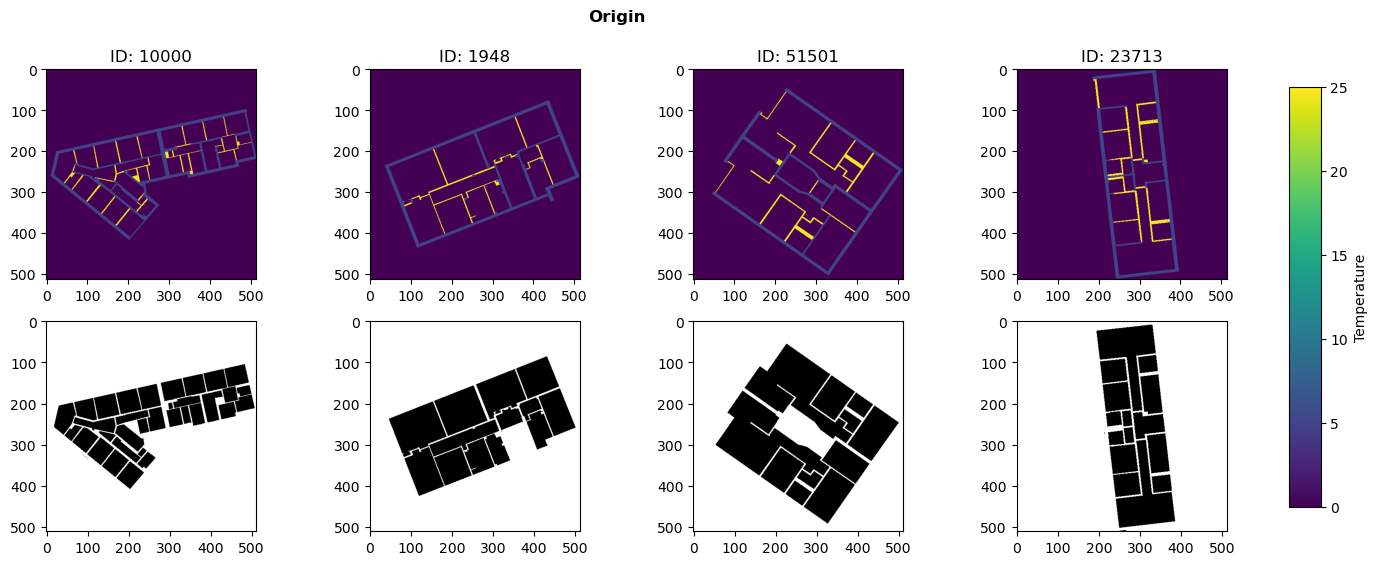

In [8]:

# Load floor plans
all_u0 = np.empty((N, 514, 514))
all_interior_mask = np.empty((N, 512, 512), dtype="bool")
for i, bid in enumerate(building_ids):
    u0, interior_mask = load_data(LOAD_DIR, bid)
    all_u0[i] = u0
    all_interior_mask[i] = interior_mask

plot_rooms(building_ids, all_u0, all_interior_mask, is_mask=True, save = True, title = "Origin")
    

In [9]:
# Run jacobi iterations for each floor plan
MAX_ITER = 20_000
ABS_TOL = 1e-4

all_u = np.empty_like(all_u0)
for i, (u0, interior_mask) in enumerate(zip(all_u0, all_interior_mask)):
    u = jacobi(u0, interior_mask, MAX_ITER, ABS_TOL)
    all_u[i] = u


print(all_u.shape) 

# Shape of all_u and all_interior_mask
# (N, 514, 514)

(4, 514, 514)


In [10]:
# Print summary statistics in CSV format
stat_keys = ["mean_temp", "std_temp", "pct_above_18", "pct_below_15"]
print("building_id," + ",".join(stat_keys))  # CSV header
for bid, u, interior_mask in zip(building_ids, all_u, all_interior_mask):
    stats = summary_stats(u, interior_mask)
    print(f"{bid},", ",".join(str(stats[k]) for k in stat_keys))

building_id,mean_temp,std_temp,pct_above_18,pct_below_15
10000, 14.01233878811275,6.367431059312565,30.941014791508444,55.542295034537624
1948, 15.021896598133893,6.852638728965046,39.44778341420379,50.10889942655492
51501, 15.645708715398605,6.641196916626103,44.11601049272663,45.05172550845437
23713, 14.755361469388765,7.336457189325107,39.74504060710957,52.71102383171349


<Figure size 640x480 with 0 Axes>

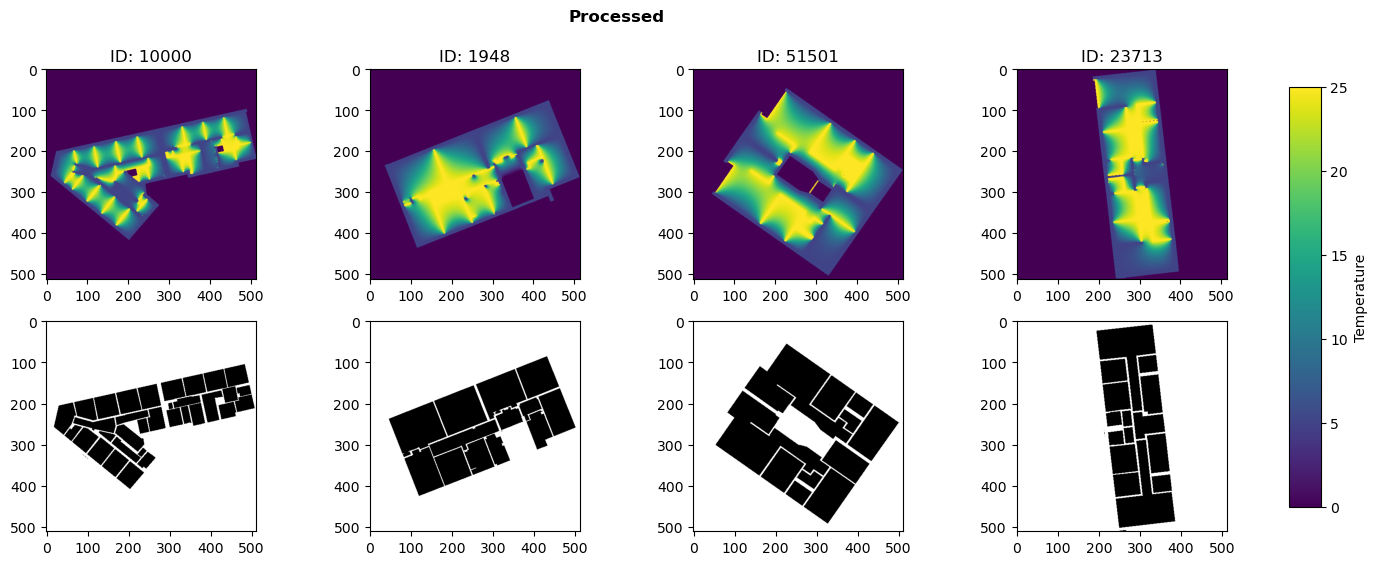

<Figure size 640x480 with 0 Axes>

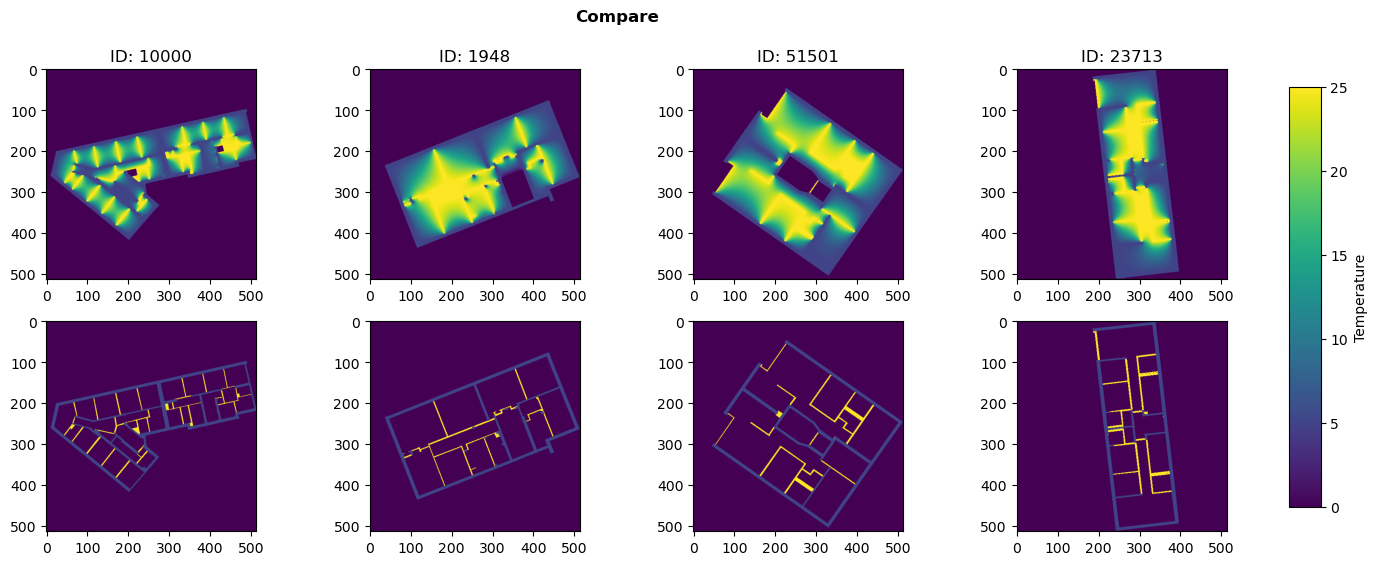

In [11]:
plot_rooms(building_ids, all_u, all_interior_mask, is_mask=True, save = True, title = "Processed")
plot_rooms(building_ids, all_u, all_u0, is_mask=False, save = True, title = "Compare")